## v3

In [1]:
import pandas as pd
fluency = pd.read_csv('llama/whisper-v3-llama-response-fluency.csv')
richness = pd.read_csv('llama/whisper-v3-llama-response-richness.csv')
correlation = pd.read_csv('llama/whisper-v3-llama-response-correlation.csv')
grammar = pd.read_csv('llama/whisper-v3-llama-response-grammar.csv')
# repeatability = pd.read_csv('llama/whisper-v3-llama-response-repeatability.csv')
# combine = pd.concat([fluency["file"], fluency["AD"], fluency["eval"], richness["eval"], correlation["eval"], grammar["eval"]], repeatability["eval"], axis=1,
#           keys=['file', 'dementia', 'fluency', 'richness', 'correlation', 'grammar', 'repeatability'])
combine = pd.concat([fluency["file"], fluency["AD"], fluency["eval"], richness["eval"], correlation["eval"], grammar["eval"]], axis=1,
          keys=['file', 'dementia', 'fluency', 'richness', 'correlation', 'grammar'])
combine.to_csv("llama/whisper-v3-llama.csv", index=False)
combine

,file,dementia,fluency,richness,correlation,grammar
0,1,0,3.5,3.5,3.5,3.5
1,2,0,3.5,3.5,3.5,2.5
2,3,0,3.5,3.5,3.5,3.5
3,4,1,2.5,2.5,2.5,2.5
4,5,1,3.0,2.5,2.5,3.0
...,...,...,...,...,...,...
83,96,0,2.5,3.0,3.5,2.0
84,97,0,3.5,3.5,3.5,3.5
85,98,0,3.5,3.5,3.5,3.5
86,99,0,3.5,3.5,3.5,3.5


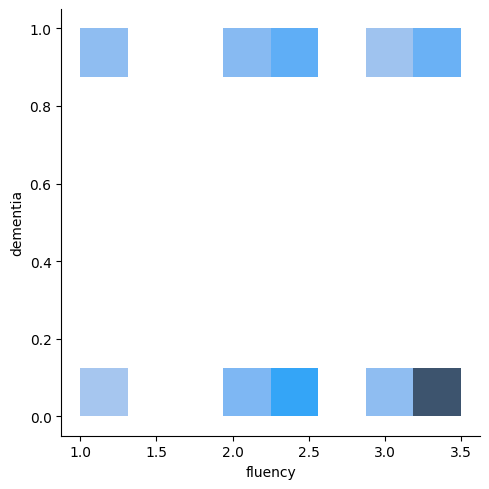

In [3]:
import seaborn as sns
sns.displot(combine, x="fluency", y="dementia")

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
# os.environ['CUDA_VISIBLE_DEVICES']='0,1'
os.environ['CUDA_LAUNCH_BLOCKING']='1'
import torch
# torch.cuda.set_device(0)
print(torch.cuda.current_device())
#! python
# -*- coding: utf-8 -*-
# Author: kun
# @Time: 2019-10-29 20:29

import yaml
import argparse
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

class Para(object):
    a=1

def list_5fold():
    path_list = []
    for idx in range(5):
        path = "data_process/CTT5-" + str(idx+1) + "-2"
        for f in os.listdir(path):
            file = int(str(f).split("CTT")[0].split('/')[-1])
            path_list.append({"file": file, "5fold": idx+1})
    return path_list

def main():
    # For reproducibility, comment these may speed up training
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print("start")
    
    path_list = pd.DataFrame(list_5fold())
    path_list = path_list.sort_values(by='file', ascending=True)
    # path_list.set_index("file" , inplace=True)
    path_list = path_list.reset_index()
    # print(path_list)

    response = pd.read_csv('llama/whisper-v3-llama.csv')
    # response = response.replace({'eval': {-1: 1}})
    # print(response)
    response["5fold"] = path_list["5fold"]

    feature = response.drop(columns = ['file', 'dementia']).astype(np.int64).to_numpy()
    # feature = response["eval"].to_numpy()
    # feature = np.reshape(feature, (-1, 1))

    target = response["AD"].to_numpy()
    target = np.reshape(target, (-1, 1))

    # print(feature, target)
    
    alldf =pd.DataFrame()
    for fold in range(0,5):
        # 5 fold
        train = []
        valid = []
        t_tra = []
        t_val = []
        name = []
        # y_predicted_val = []
        idx = 0

        for idx in range(feature.shape[0]):
            if(int(response["5fold"][idx]) != int(str(fold+1))):
                train.append(feature[idx])
                t_tra.append(target[idx])
            else:
                valid.append(feature[idx])
                t_val.append(target[idx])
                # if(feature[idx]>=5):
                #     y_predicted_val.append(0)
                # else:
                #     y_predicted_val.append(1)                    
                name.append(response["file"][idx])

        train = np.array(train)
        t_tra = np.array(t_tra)
        valid = np.array(valid)
        t_val = np.array(t_val)
        name = np.array(name)
        # name = np.reshape(name, (-1, 1)) 
        
        print("fold: ", fold)
        
        # clf = SVC(kernel='linear')
        clf = make_pipeline(StandardScaler(), SVC(kernel='linear'))

        # Fit the model to the data
        clf.fit(train, t_tra.ravel())
        # print(train, t_tra)
#         print(reg.coef_)
        y_predicted = clf.predict(train)
#         loss = mean_squared_error(t_tra, y_predicted)
        y_predicted_val = clf.predict(valid)
        # y_predicted_val = np.reshape(y_predicted_val, (-1, 1)) 
#         loss_val = mean_squared_error(t_val, y_predicted_val)
#         print("loss ", loss, "loss_val", loss_val)

        
        # pipeline = Pipeline([
        #     ('scaler', StandardScaler()), 
        #     ('svc', SVC())
        # ])

        # param_grid = {
        #     'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        #     'svc__C': [0.1, 1, 10, 100],
        #     'svc__gamma': ['scale', 'auto'], 
        #     'svc__degree': [2, 3, 4] 
        # }

        # grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2, n_jobs=-1)
        # grid_search.fit(train, t_tra.ravel())

        # print("Best Parameters: ", grid_search.best_params_)
        # best_clf = grid_search.best_estimator_
        # y_predicted_val = best_clf.predict(valid)

        train = np.reshape(train, (-1,))
        t_tra = np.reshape(t_tra, (-1,))
        valid = np.reshape(valid, (-1,))
        t_val = np.reshape(t_val, (-1,))

        # print('train:', train)
        # print(t_tra)
        # print("valid", valid)
        # print(y_predicted_val)

        # plt.scatter(train, t_tra, cmap=plt.cm.coolwarm)
        # plt.xlabel('Sepal length')
        # plt.ylabel('Sepal width')
        # plt.xticks(())
        # plt.yticks(())
        # plt.show()
        
        # print(name, y_predicted_val, t_val)
        df = pd.DataFrame(
            {'name': name,
             'result': y_predicted_val,
             'truth': t_val,
            #  'eval': valid
            })
        alldf = pd.concat([alldf, df])#
#         print(df)
        # df.to_csv(f'biclass_result/5folds_biclass_{fold+1}_pause_e.csv', index=False)
    alldf.to_csv("biclass_result/llama-v3.csv", index=False) 
    return True


In [ ]:
main()

In [ ]:
llama_v3 = pd.read_csv('biclass_result/llama-v3.csv')
# fivefolds_1k['result'] = np.where(fivefolds_1k['result'] >= 0.5,1,0)
# llama_v3.head(50)
llama_v3

In [ ]:
# fivefolds_1_result = fivefolds_1k['result'].tolist()
# fivefolds_1_truth = [int(i) for i in fivefolds_1k['truth'].tolist()]
from sklearn import metrics

llama_v3_result = llama_v3['result'].tolist()
llama_v3_truth = llama_v3['truth'].tolist()

llama_v3_wrong = llama_v3.iloc[np.where(llama_v3['result'] != llama_v3['truth'])]
print(llama_v3_wrong)

target_names = ['non-patient', 'patient']
clf_report = metrics.classification_report(llama_v3_truth, llama_v3_result, target_names=target_names)
print(clf_report)

tn, fp, fn, tp = metrics.confusion_matrix(llama_v3_truth, llama_v3_result).ravel()
print('sensitivuty: ',tp / (fn+tp))
print('specificity: ',tn / (fp+tn))

# fpr, tpr, thresholds = metrics.roc_curve(np.array(llama_v3_truth), np.array(llama_v3_result), pos_label=1)
# print('AUC: ',metrics.auc(fpr, tpr))
# fpr1, tpr1, thresholds1 = metrics.roc_curve(np.array(llama_v3_truth[0:19]), np.array(llama_v3_result[0:19]), pos_label=1)
# auc1 = metrics.auc(fpr1, tpr1)
# fpr2, tpr2, thresholds2 = metrics.roc_curve(np.array(llama_v3_truth[37:54]), np.array(llama_v3_result[37:54]), pos_label=1)
# auc2 = metrics.auc(fpr2, tpr2)
# fpr3, tpr3, thresholds3 = metrics.roc_curve(np.array(llama_v3_truth[37:54]), np.array(llama_v3_result[37:54]), pos_label=1)
# auc3 = metrics.auc(fpr3, tpr3)
# fpr4, tpr4, thresholds4 = metrics.roc_curve(np.array(llama_v3_truth[37:54]), np.array(llama_v3_result[37:54]), pos_label=1)
# auc4 = metrics.auc(fpr4, tpr4)
# fpr5, tpr5, thresholds5 = metrics.roc_curve(np.array(llama_v3_truth[37:54]), np.array(llama_v3_result[37:54]), pos_label=1)
# auc5 = metrics.auc(fpr5, tpr5)
# print('AUC: ', auc1, auc2, auc3, auc4, auc5)
# print("AUC_avg: ", (auc1+auc2+auc3+auc4+auc5)/5)

y_test = [bool(int(x)) for x in llama_v3_truth]
y_pred = [bool(int(x)) for x in llama_v3_result]
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

## v2

In [1]:
import pandas as pd
# fluency = pd.read_csv('llama/diarization_overlap/whisper-v2-llama-response-fluency.csv')
# richness = pd.read_csv('llama/diarization_overlap/whisper-v2-llama-response-richness.csv')
# correlation = pd.read_csv('llama/diarization_overlap/whisper-v2-llama-response-correlation.csv')
# grammar = pd.read_csv('llama/diarization_overlap/whisper-v2-llama-response-grammar.csv')
# complexity = pd.read_csv('llama/diarization_overlap/whisper-v2-llama-response-complexity.csv')
# fluency = pd.read_csv('chatgpt/remove/whisper-v2-gpt-response-fluency.csv')
# richness = pd.read_csv('chatgpt/remove/whisper-v2-gpt-response-richness.csv')
# correlation = pd.read_csv('chatgpt/remove/whisper-v2-gpt-response-correlation.csv')
# grammar = pd.read_csv('chatgpt/remove/whisper-v2-gpt-response-grammar.csv')
# complexity = pd.read_csv('chatgpt/remove/whisper-v2-gpt-response-complexity.csv')

fluency = pd.read_csv('chatgpt/chatgpt3/whisper-v2-gpt3-response-fluency.csv')
richness = pd.read_csv('chatgpt/chatgpt3/whisper-v2-gpt3-response-richness.csv')
correlation = pd.read_csv('chatgpt/chatgpt3/whisper-v2-gpt3-response-correlation.csv')
grammar = pd.read_csv('chatgpt/chatgpt3/whisper-v2-gpt3-response-grammar.csv')
complexity = pd.read_csv('chatgpt/chatgpt3/whisper-v2-gpt3-response-complexity.csv')
# repeatability = pd.read_csv('llama/whisper-v2-llama-response-repeatability.csv')
# combine = pd.concat([fluency["file"], fluency["AD"], fluency["eval"], richness["eval"], correlation["eval"], grammar["eval"]], repeatability["eval"], axis=1,
#           keys=['file', 'dementia', 'fluency', 'richness', 'correlation', 'grammar', 'repeatability'])
combine = pd.concat([fluency["file"], fluency["AD"], fluency["eval"], richness["eval"], correlation["eval"], grammar["eval"], complexity["eval"]], axis=1,
          keys=['file', 'dementia', 'fluency', 'richness', 'correlation', 'grammar', 'complexity'])
combine.to_csv("chatgpt/chatgpt3/whisper-v2-chatgpt.csv", index=False)
combine

,file,dementia,fluency,richness,correlation,grammar,complexity
0,1,0,3,2,3,4,3
1,2,0,3,2,2,2,2
2,3,0,3,2,2,2,2
3,4,1,2,2,2,2,2
4,5,1,2,2,2,2,2
...,...,...,...,...,...,...,...
81,96,0,7,4,3,4,2
82,97,0,2,2,2,2,2
83,98,0,3,3,3,2,3
84,99,0,2,3,3,4,3


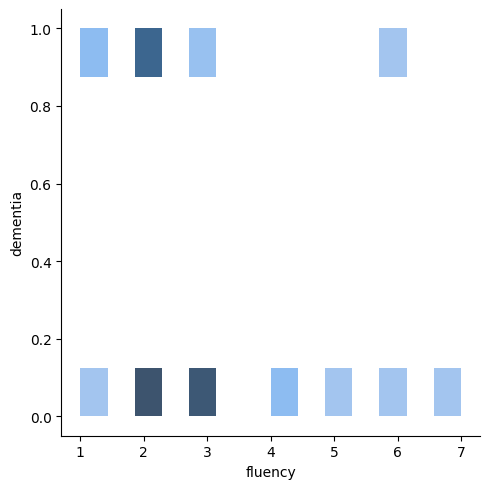

In [2]:
import seaborn as sns
sns.displot(combine, x="fluency", y="dementia")

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
# os.environ['CUDA_VISIBLE_DEVICES']='0,1'
os.environ['CUDA_LAUNCH_BLOCKING']='1'
import torch
# torch.cuda.set_device(0)
print(torch.cuda.current_device())
#! python
# -*- coding: utf-8 -*-
# Author: kun
# @Time: 2019-10-29 20:29

import yaml
import argparse
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


class Para(object):
    a=1

def list_5fold():
    path_list = []
    for idx in range(5):
        path = "data_process/CTT5-" + str(idx+1) + "-2"
        for f in os.listdir(path):
            file = int(str(f).split("CTT")[0].split('/')[-1])
            path_list.append({"file": file, "5fold": idx+1})
    return path_list

def main():
    # For reproducibility, comment these may speed up training
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print("start")
    
    path_list = pd.DataFrame(list_5fold())
    path_list = path_list.sort_values(by='file', ascending=True)
    # path_list.set_index("file" , inplace=True)
    path_list = path_list.reset_index()
    # print(path_list)

    response = pd.read_csv('chatgpt/chatgpt3/whisper-v2-chatgpt.csv')
    # response = response.replace({'eval': {-1: 1}})
    # print(response)
    response["5fold"] = path_list["5fold"]

    feature = response.drop(columns = ['file', 'dementia', '5fold']).astype(np.int64).to_numpy()
    # feature = response["eval"].to_numpy()
    # feature = np.reshape(feature, (-1, 1))

    target = response["dementia"].to_numpy()
    target = np.reshape(target, (-1, 1))
    # print(response, feature, target)
    
    alldf =pd.DataFrame()
    for fold in range(0,5):
        # 5 fold
        train = []
        valid = []
        t_tra = []
        t_val = []
        name = []
        # y_predicted_val = []
        idx = 0

        for idx in range(feature.shape[0]):
            if(int(response["5fold"][idx]) != int(str(fold+1))):
                train.append(feature[idx])
                t_tra.append(target[idx])
            else:
                valid.append(feature[idx])
                t_val.append(target[idx])
                # if(feature[idx]>=5):
                #     y_predicted_val.append(0)
                # else:
                #     y_predicted_val.append(1)                    
                name.append(response["file"][idx])

        train = np.array(train)
        t_tra = np.array(t_tra)
        valid = np.array(valid)
        t_val = np.array(t_val)
        name = np.array(name)
        # name = np.reshape(name, (-1, 1)) 
        
        print("fold: ", fold)
        
        # ds = DecisionTreeClassifier()
        # knn = KNeighborsClassifier()
        # svc = SVC(kernel='poly', C=1, gamma="auto", degree=3, probability=True)
        svc = SVC(kernel='linear', C=10000, gamma="auto", probability=True)
        # clf = BaggingClassifier(base_estimator=svc, n_estimators=10, random_state=0)
        clf = make_pipeline(StandardScaler(), svc)

        # Fit the model to the data
        clf.fit(train, t_tra.ravel())
        # print(train, t_tra)
#         print(reg.coef_)
        y_predicted = clf.predict(train)
#         loss = mean_squared_error(t_tra, y_predicted)
        y_predicted_val = clf.predict(valid)
        y_predicted_val_pro = clf.predict_proba(valid)
        y_predicted_val_pro = [row[1] for row in y_predicted_val_pro]

        # feature_import = pd.Series(imp, index=names).nlargest(4).plot(kind='barh')
        # print(feature_import)

        # y_predicted_val = np.reshape(y_predicted_val, (-1, 1)) 
#         loss_val = mean_squared_error(t_val, y_predicted_val)
#         print("loss ", loss, "loss_val", loss_val)

        
        # pipeline = Pipeline([
        #     ('scaler', StandardScaler()), 
        #     ('feature_selection', SelectKBest(score_func=f_classif)), 
        #     ('svc', SVC(probability=True, random_state=1))
        # ])

        # param_grid = {
        #     'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        #     'svc__C': [0.01, 0.1, 1, 10, 100, 1000],
        #     'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        #     # 'svc__gamma': ['auto', 'scale'],  
        #     'svc__degree': [2, 3, 4],
        #     'feature_selection__k': [2, 3, 4],  # 尝试不同数量的特征
        #     'svc__class_weight': [None, 'balanced'],  # 尝试平衡类权重
        #     'svc__decision_function_shape': ['ovo', 'ovr'],  # 尝试一对一和一对多策略
        # }

        # grid_search = GridSearchCV(pipeline, param_grid)
        # grid_search.fit(train, t_tra.ravel())

        # print("Best Parameters: ", grid_search.best_params_)
        # best_clf = grid_search.best_estimator_
        # y_predicted_val = best_clf.predict(valid)
        # y_predicted_val_pro = best_clf.predict_proba(valid)
        # y_predicted_val_pro = [row[1] for row in y_predicted_val_pro]

        imp = svc.coef_
        imp = abs(imp[0])
        print(imp)   
        names = ['fluency', 'richness', 'correlation', 'grammar', 'complexity']
        imp,names = zip(*sorted(zip(imp,names)))
        plt.barh(range(len(names)), imp, align='center')
        plt.yticks(range(len(names)), names)
        plt.show()

        train = np.reshape(train, (-1,))
        t_tra = np.reshape(t_tra, (-1,))
        valid = np.reshape(valid, (-1,))
        t_val = np.reshape(t_val, (-1,))
        y_predicted_val_pro = np.reshape(y_predicted_val_pro, (-1,))

        # print('train:', train)
        # print(t_tra)
        # print("valid", valid)
        # print(y_predicted_val)

        # plt.scatter(train, t_tra, cmap=plt.cm.coolwarm)
        # plt.xlabel('Sepal length')
        # plt.ylabel('Sepal width')
        # plt.xticks(())
        # plt.yticks(())
        # plt.show()
        
        # print(name, y_predicted_val, t_val)
        df = pd.DataFrame(
            {'name': name,
             'result': y_predicted_val,
             'truth': t_val,
             'hyps': y_predicted_val_pro
            })
        alldf = pd.concat([alldf, df])#
#         print(df)
        # df.to_csv(f'biclass_result/5folds_biclass_{fold+1}_pause_e.csv', index=False)
    alldf.to_csv("biclass_result/gpt3-v2-r-final.csv", index=False) 
    return True


0


start
fold:  0
[0.70397794 0.31259634 0.29408116 0.25631558 0.2200916 ]


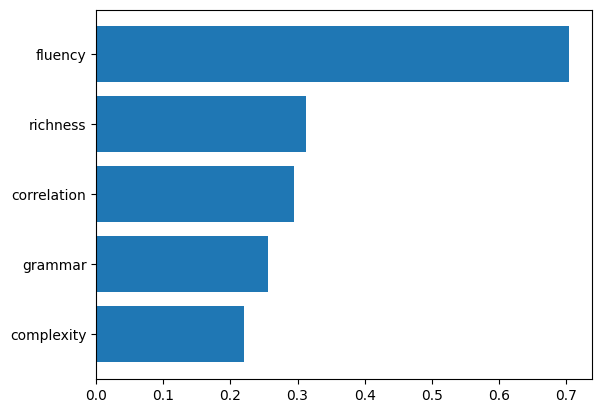

fold:  1
[0.0043756  0.00342943 0.00310447 0.0012921  0.00129675]


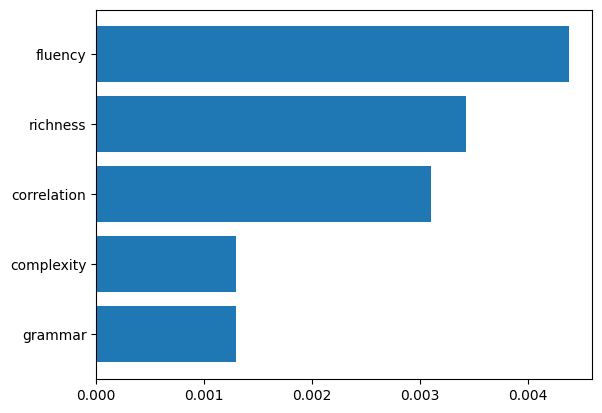

fold:  2
[1.95753417 0.53524431 0.40250867 0.00288495 0.30118491]


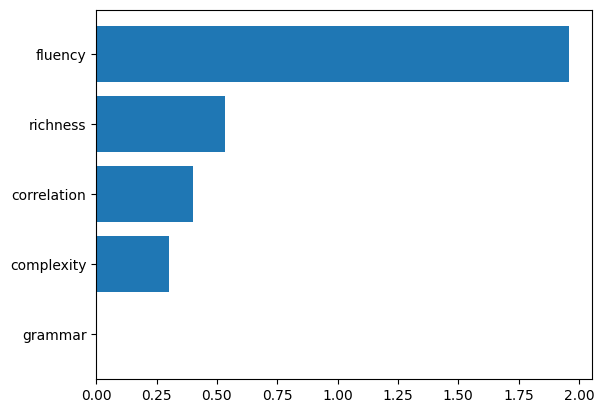

fold:  3
[9.08841013e-01 2.35978237e-04 7.13578729e-04 2.88512021e-03
 6.46773004e-01]


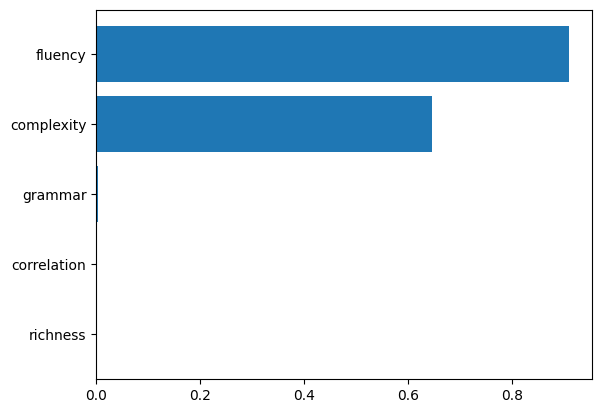

fold:  4
[1.06678820e+00 1.20663307e-01 2.09904519e-01 1.04561358e-03
 4.30219799e-01]


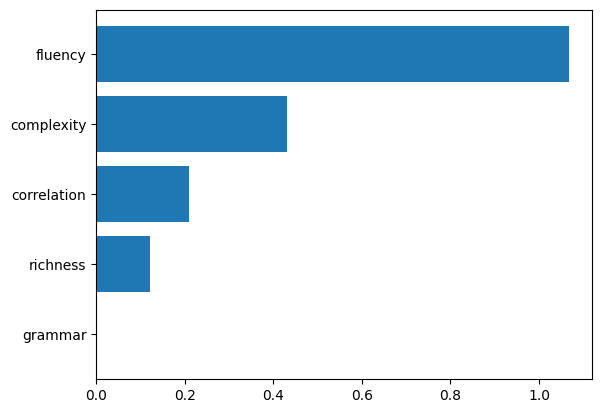

True

In [4]:
main()

## results

In [1]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve, auc, f1_score, recall_score
import numpy as np
from scipy.stats import sem, t

def eval_std_ci(truth_df, hyps_df, result_df):
    f1_scores = []
    sensitivities = []
    specificities = []
    aucs = []
    fold_indices = [(0, 17), (17, 35), (35, 52), (52, 69), (69, 86)]

    for start, end in fold_indices:
        truth = np.array(truth_df[start:end])
        hyps = np.array(hyps_df[start:end])
        # hyps_binary = (hyps >= 0.5).astype(int)
        hyps_binary = np.array(result_df[start:end])

        f1 = f1_score(truth, hyps_binary)
        f1_scores.append(f1)
        sensitivity = recall_score(truth, hyps_binary)
        sensitivities.append(sensitivity)
        cm = confusion_matrix(truth, hyps_binary)
        tn = cm[0, 0]
        fp = cm[0, 1]
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        specificities.append(specificity)
        fpr, tpr, _ = roc_curve(truth, hyps, pos_label=1)
        auc_score = auc(fpr, tpr)
        aucs.append(auc_score)

    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    mean_sensitivity = np.mean(sensitivities)
    std_sensitivity = np.std(sensitivities)
    mean_specificity = np.mean(specificities)
    std_specificity = np.std(specificities)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    conf_interval_f1 = t.interval(0.95, len(f1_scores)-1, loc=mean_f1, scale=std_f1/np.sqrt(len(f1_scores)))
    conf_interval_sensitivity = t.interval(0.95, len(sensitivities)-1, loc=mean_sensitivity, scale=std_sensitivity/np.sqrt(len(sensitivities)))
    conf_interval_specificity = t.interval(0.95, len(specificities)-1, loc=mean_specificity, scale=std_specificity/np.sqrt(len(specificities)))
    conf_interval_auc = t.interval(0.95, len(aucs)-1, loc=mean_auc, scale=std_auc/np.sqrt(len(aucs)))

    def adjust_confidence_interval(conf_interval):
        return (max(0, min(conf_interval[0], 1)), max(0, min(conf_interval[1], 1)))

    conf_interval_f1 = adjust_confidence_interval(conf_interval_f1)
    conf_interval_sensitivity = adjust_confidence_interval(conf_interval_sensitivity)
    conf_interval_specificity = adjust_confidence_interval(conf_interval_specificity)
    conf_interval_auc = adjust_confidence_interval(conf_interval_auc)


    return f1_scores, sensitivities, specificities, aucs, mean_f1, mean_sensitivity, mean_specificity, mean_auc, std_f1, std_sensitivity, std_specificity, std_auc, conf_interval_f1, conf_interval_sensitivity, conf_interval_specificity, conf_interval_auc

In [2]:
import pandas as pd
llama_v2 = pd.read_csv('biclass_result/gpt3-v2-r-final.csv')
# fivefolds_1k['result'] = np.where(fivefolds_1k['result'] >= 0.5,1,0)
# llama_v2.head(50)
llama_v2

,name,result,truth,hyps
0,15,0,0,0.390179
1,16,1,1,0.446688
2,22,1,0,0.418032
3,28,0,1,0.390638
4,34,0,0,0.338963
...,...,...,...,...
81,72,0,0,0.322367
82,73,0,0,0.273154
83,79,0,0,0.269589
84,90,1,0,0.371349


    name  result  truth      hyps
2     22       1      0  0.418032
3     28       0      1  0.390638
6     40       0      1  0.338762
9     53       1      0  0.418151
12    83       1      0  0.418032
15    97       1      0  0.418032
18    11       0      1  0.292896
19    25       0      1  0.293042
20    37       0      1  0.292914
21    39       0      1  0.293241
22    45       0      1  0.293042
23    46       0      1  0.293130
24    65       0      1  0.292842
25    67       0      1  0.293042
37    18       0      1  0.425232
40    32       0      1  0.207870
41    38       0      1  0.345665
44    57       0      1  0.001300
45    58       0      1  0.397075
52     4       0      1  0.373899
55     9       0      1  0.373946
56    12       0      1  0.373813
57    17       0      1  0.334273
58    21       1      0  0.416396
62    63       0      1  0.334106
71    10       0      1  0.293439
73    14       1      0  0.375411
84    90       1      0  0.371349
85    95      

Text(0.5, 1.0, 'ChatGPT -r')

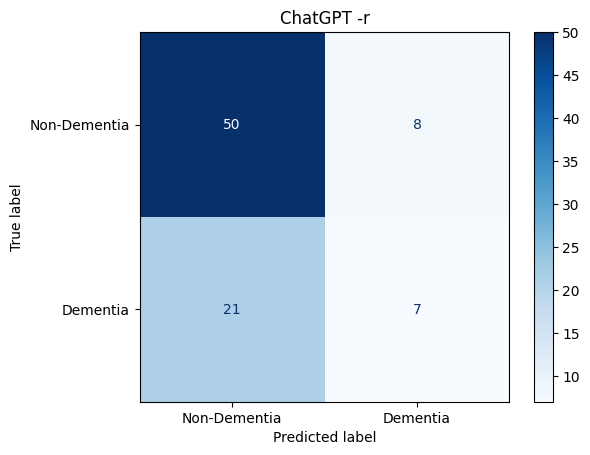

In [3]:
import numpy as np
from sklearn import metrics

llama_v2_hyps = llama_v2['hyps'].tolist()
llama_v2_result = llama_v2['result'].tolist()
llama_v2_truth = llama_v2['truth'].tolist()

llama_v2_wrong = llama_v2.iloc[np.where(llama_v2['result'] != llama_v2['truth'])]
print(llama_v2_wrong)

target_names = ['non-patient', 'patient']
clf_report = metrics.classification_report(llama_v2_truth, llama_v2_result, target_names=target_names)
print(clf_report)

tn, fp, fn, tp = metrics.confusion_matrix(llama_v2_truth, llama_v2_result).ravel()
print('sensitivuty: ',tp / (fn+tp))
print('specificity: ',tn / (fp+tn))

# fpr, tpr, thresholds = metrics.roc_curve(np.array(llama_v2_truth), np.array(llama_v2_hyps), pos_label=1)
# print('AUC: ',metrics.auc(fpr, tpr))
# fpr1, tpr1, thresholds1 = metrics.roc_curve(np.array(llama_v2_truth[0:19]), np.array(llama_v2_hyps[0:19]), pos_label=1)
# auc1 = metrics.auc(fpr1, tpr1)
# fpr2, tpr2, thresholds2 = metrics.roc_curve(np.array(llama_v2_truth[19:37]), np.array(llama_v2_hyps[19:37]), pos_label=1)
# auc2 = metrics.auc(fpr2, tpr2)
# fpr3, tpr3, thresholds3 = metrics.roc_curve(np.array(llama_v2_truth[37:54]), np.array(llama_v2_hyps[37:54]), pos_label=1)
# auc3 = metrics.auc(fpr3, tpr3)
# fpr4, tpr4, thresholds4 = metrics.roc_curve(np.array(llama_v2_truth[54:71]), np.array(llama_v2_hyps[54:71]), pos_label=1)
# auc4 = metrics.auc(fpr4, tpr4)
# fpr5, tpr5, thresholds5 = metrics.roc_curve(np.array(llama_v2_truth[71:88]), np.array(llama_v2_hyps[71:88]), pos_label=1)
# auc5 = metrics.auc(fpr5, tpr5)
# print('AUC: ', auc1, auc2, auc3, auc4, auc5)
# print("AUC_avg: ", (auc1+auc2+auc3+auc4+auc5)/5)

f1_scores, sensitivities, specificities, aucs, \
mean_f1, mean_sensitivity, mean_specificity, mean_auc, \
std_f1, std_sensitivity, std_specificity, std_auc, \
conf_interval_f1, conf_interval_sensitivity, conf_interval_specificity, conf_interval_auc = eval_std_ci(llama_v2_truth, llama_v2_hyps, llama_v2_result)
print(f"F1 Scores: {f1_scores}, Sensitivities: {sensitivities}, Specificities: {specificities}, AUCs: {aucs}")
print(f"Mean F1 Score: {mean_f1}, Std Dev: {std_f1}, 95% Confidence Interval: {conf_interval_f1}")
print(f"Mean Sensitivity: {mean_sensitivity}, Std Dev: {std_sensitivity}, 95% Confidence Interval: {conf_interval_sensitivity}")
print(f"Mean Specificity: {mean_specificity}, Std Dev: {std_specificity}, 95% Confidence Interval: {conf_interval_specificity}")
print(f"Mean AUC: {mean_auc}, Std Dev: {std_auc}, 95% Confidence Interval: {conf_interval_auc}")

y_test = [bool(int(x)) for x in llama_v2_truth]
y_pred = [bool(int(x)) for x in llama_v2_result]
labels = ['Non-Dementia', 'Dementia']
display = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels, cmap="Blues")
display.ax_.set_title("ChatGPT -r")

In [4]:
# # 20, 38, 55, 72, 88

# print(llama_v2[0:19])
# print(llama_v2[19:37])
# print(llama_v2[37:54])
# print(llama_v2[54:71])
# print(llama_v2[71:88])

# fpr1, tpr1, thresholds1 = metrics.roc_curve(np.array(llama_v2_truth[0:19]), np.array(llama_v2_result[0:19]), pos_label=1)
# auc1 = metrics.auc(fpr1, tpr1)
# fpr2, tpr2, thresholds2 = metrics.roc_curve(np.array(llama_v2_truth[37:54]), np.array(llama_v2_result[37:54]), pos_label=1)
# auc2 = metrics.auc(fpr2, tpr2)
# fpr3, tpr3, thresholds3 = metrics.roc_curve(np.array(llama_v2_truth[37:54]), np.array(llama_v2_result[37:54]), pos_label=1)
# auc3 = metrics.auc(fpr3, tpr3)
# fpr4, tpr4, thresholds4 = metrics.roc_curve(np.array(llama_v2_truth[37:54]), np.array(llama_v2_result[37:54]), pos_label=1)
# auc4 = metrics.auc(fpr4, tpr4)
# fpr5, tpr5, thresholds5 = metrics.roc_curve(np.array(llama_v2_truth[37:54]), np.array(llama_v2_result[37:54]), pos_label=1)
# auc5 = metrics.auc(fpr5, tpr5)
# print('AUC: ', auc1, auc2, auc3, auc4, auc5)
# print("AUC_avg: ", (auc1+auc2+auc3+auc4+auc5)/5)

In [5]:
import pandas as pd
llama_v2 = pd.read_csv('biclass_result/gpt-v2-o-d-final.csv')
# fivefolds_1k['result'] = np.where(fivefolds_1k['result'] >= 0.5,1,0)
# llama_v2.head(50)
llama_v2

,name,result,truth,hyps
0,15,1,0,0.454677
1,16,1,1,0.916269
2,22,0,0,0.260503
3,28,1,1,0.454334
4,34,0,0,0.260851
...,...,...,...,...
81,72,0,0,0.195233
82,73,0,0,0.031494
83,79,0,0,0.195486
84,90,0,0,0.195540


    name  result  truth      hyps
0     15       1      0  0.454677
5     35       0      1  0.260760
6     40       0      1  0.260989
8     51       1      0  0.662333
20    37       0      1  0.243271
22    45       0      1  0.243025
31    78       1      0  0.489339
40    32       0      1  0.278481
41    38       0      1  0.220937
44    57       0      1  0.147061
56    12       0      1  0.255054
60    54       1      0  0.534477
71    10       0      1  0.004130
73    14       1      0  0.650514
74    24       0      1  0.195551
80    69       1      0  0.934634
              precision    recall  f1-score   support

 non-patient       0.84      0.90      0.87        58
     patient       0.75      0.64      0.69        28

    accuracy                           0.81        86
   macro avg       0.79      0.77      0.78        86
weighted avg       0.81      0.81      0.81        86

sensitivuty:  0.6428571428571429
specificity:  0.896551724137931
F1 Scores: [0.5, 0.79999999999

Text(0.5, 1.0, 'ChatGPT -p')

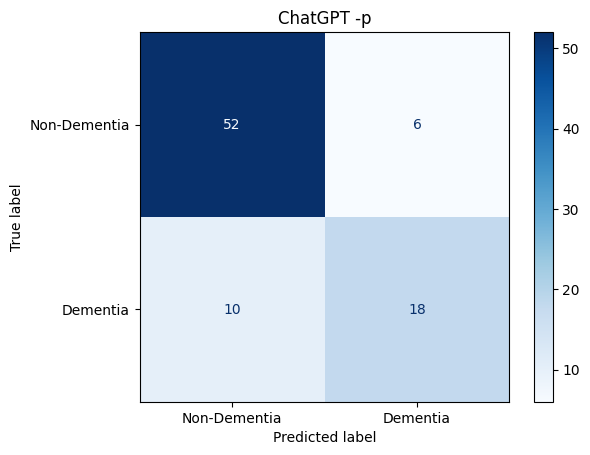

In [6]:
import numpy as np
from sklearn import metrics

llama_v2_hyps = llama_v2['hyps'].tolist()
llama_v2_result = llama_v2['result'].tolist()
llama_v2_truth = llama_v2['truth'].tolist()

llama_v2_wrong = llama_v2.iloc[np.where(llama_v2['result'] != llama_v2['truth'])]
print(llama_v2_wrong)

target_names = ['non-patient', 'patient']
clf_report = metrics.classification_report(llama_v2_truth, llama_v2_result, target_names=target_names)
print(clf_report)

tn, fp, fn, tp = metrics.confusion_matrix(llama_v2_truth, llama_v2_result).ravel()
print('sensitivuty: ',tp / (fn+tp))
print('specificity: ',tn / (fp+tn))

# fpr, tpr, thresholds = metrics.roc_curve(np.array(llama_v2_truth), np.array(llama_v2_hyps), pos_label=1)
# print('AUC: ',metrics.auc(fpr, tpr))
# fpr1, tpr1, thresholds1 = metrics.roc_curve(np.array(llama_v2_truth[0:19]), np.array(llama_v2_hyps[0:19]), pos_label=1)
# auc1 = metrics.auc(fpr1, tpr1)
# fpr2, tpr2, thresholds2 = metrics.roc_curve(np.array(llama_v2_truth[19:37]), np.array(llama_v2_hyps[19:37]), pos_label=1)
# auc2 = metrics.auc(fpr2, tpr2)
# fpr3, tpr3, thresholds3 = metrics.roc_curve(np.array(llama_v2_truth[37:54]), np.array(llama_v2_hyps[37:54]), pos_label=1)
# auc3 = metrics.auc(fpr3, tpr3)
# fpr4, tpr4, thresholds4 = metrics.roc_curve(np.array(llama_v2_truth[54:71]), np.array(llama_v2_hyps[54:71]), pos_label=1)
# auc4 = metrics.auc(fpr4, tpr4)
# fpr5, tpr5, thresholds5 = metrics.roc_curve(np.array(llama_v2_truth[71:88]), np.array(llama_v2_hyps[71:88]), pos_label=1)
# auc5 = metrics.auc(fpr5, tpr5)
# print('AUC: ', auc1, auc2, auc3, auc4, auc5)
# print("AUC_avg: ", (auc1+auc2+auc3+auc4+auc5)/5)

f1_scores, sensitivities, specificities, aucs, \
mean_f1, mean_sensitivity, mean_specificity, mean_auc, \
std_f1, std_sensitivity, std_specificity, std_auc, \
conf_interval_f1, conf_interval_sensitivity, conf_interval_specificity, conf_interval_auc = eval_std_ci(llama_v2_truth, llama_v2_hyps, llama_v2_result)
print(f"F1 Scores: {f1_scores}, Sensitivities: {sensitivities}, Specificities: {specificities}, AUCs: {aucs}")
print(f"Mean F1 Score: {mean_f1}, Std Dev: {std_f1}, 95% Confidence Interval: {conf_interval_f1}")
print(f"Mean Sensitivity: {mean_sensitivity}, Std Dev: {std_sensitivity}, 95% Confidence Interval: {conf_interval_sensitivity}")
print(f"Mean Specificity: {mean_specificity}, Std Dev: {std_specificity}, 95% Confidence Interval: {conf_interval_specificity}")
print(f"Mean AUC: {mean_auc}, Std Dev: {std_auc}, 95% Confidence Interval: {conf_interval_auc}")

y_test = [bool(int(x)) for x in llama_v2_truth]
y_pred = [bool(int(x)) for x in llama_v2_result]
labels = ['Non-Dementia', 'Dementia']
display = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=labels, cmap="Blues")
display.ax_.set_title("ChatGPT -p")